# Testing out graph based equations approach: 1 process



In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import pymc3 as pm
import numpy as np
from bayesumis.umis_math_model import MathDistributionProcess

In [50]:
mytest = pm.Normal("hi", mu = 5, sd= 0.5)

with pm.Model():
    neg_log = pm.Lognormal('neg_log', mu=np.log(10), sd=0.02)
    norm = pm.Normal('norm', mu = 20, sd = 0.01)
    norm2 = pm.Normal('norm2', mu = 40, sd = 0.01)
    
    a = pm.Dirichlet('a', np.array([0.6,0.15,0.25]))
    
    res1 = pm.Deterministic('res1', neg_log*a[0])
    res2 = pm.Deterministic('res2', norm*a[1])
    res3 = pm.Deterministic('res3', norm2*a[2])
    
    neg_log_obs = pm.Lognormal('neg_log_obs', mu=np.log(res1), sd=0.02, observed=6)
    norm_obs = pm.Normal('norm_obs', mu = res2, sd = 0.01, observed=3)
    
    trace = pm.sample(2000, init='advi')

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6c49ef3c8>,
      dtype=object)

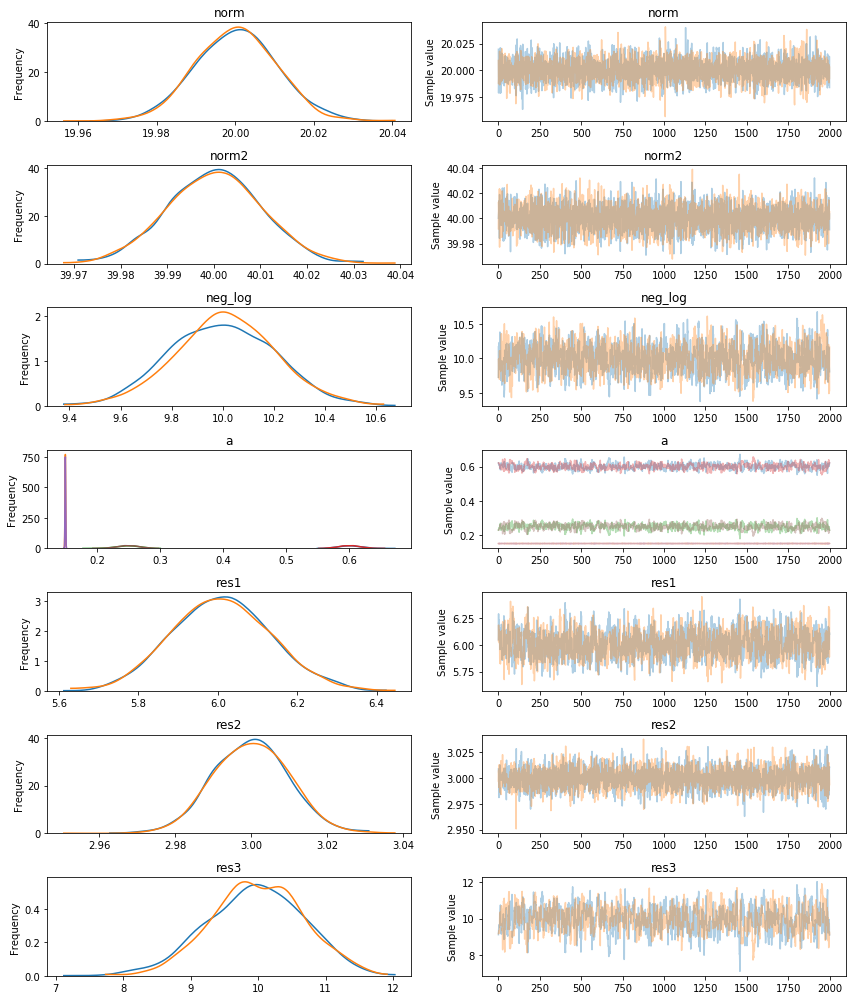

In [48]:
pm.traceplot(trace)

In [36]:
with pm.Model() as single_process_model:
    # Build model out of weak prior
    f1 = pm.Uniform('f1', lower=0, upper=1000, shape=1)
    
    print(f1)
    
#     f2 = pm.Uniform('f2', lower=0, upper=1000, shape=1)
    f2 = pm.Lognormal('f2', mu=np.log(50), sd=0.02)
    f3 = pm.Uniform('f3', lower=0, upper=1000, shape=1)
    
    s = pm.Uniform('s', lower=0, upper=100, shape=1)
    
    dist_process = MathDistributionProcess(process_name = 'a', process_ind=1, outflow_processes_names=['s', 'f3'])
    
    a = dist_process.create_param_rv()
    
    s_nl_eq = pm.Deterministic('s_nl_eq', (f1 + f2)*(a[0]))
    f3_nl_eq = pm.Deterministic('f3_nl_eq', (f1 + f2)*(a[1]))
    
    f1_l_eq = pm.Deterministic('f1_l_eq', f3_nl_eq + s_nl_eq - f2)
    f2_l_eq = pm.Deterministic('f2_l_eq', f3_nl_eq + s_nl_eq - f1_l_eq)
    f3_l_eq = pm.Deterministic('f3_l_eq', f1_l_eq + f2_l_eq - s_nl_eq)
    s_l_eq = pm.Deterministic('s_l_eq', f1_l_eq + f2_l_eq - f3_nl_eq)
    
    
    f1_obs = pm.Lognormal('f1_obs', mu=np.log(f1_l_eq), sd=0.001, observed=200)

    f2_obs = pm.Lognormal('f2_obs', mu =np.log(f2_l_eq), sd=0.002, observed=50)
    
    s_obs = pm.Normal('s_obs', mu=s_l_eq, sd=1, observed=70)
    
#     trace = pm.sample(2000, step=pm.Metropolis())
    trace = pm.sample(2000, init='advi')

    

f1


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 14.405:  16%|█▌        | 31238/200000 [00:15<01:21, 2061.89it/s]   
Convergence achieved at 31400
Interrupted at 31,399 [15%]: Average Loss = 43,962
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, s, f3, f2, f1]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 944.34draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6cfaed860>,
      dtype=object)

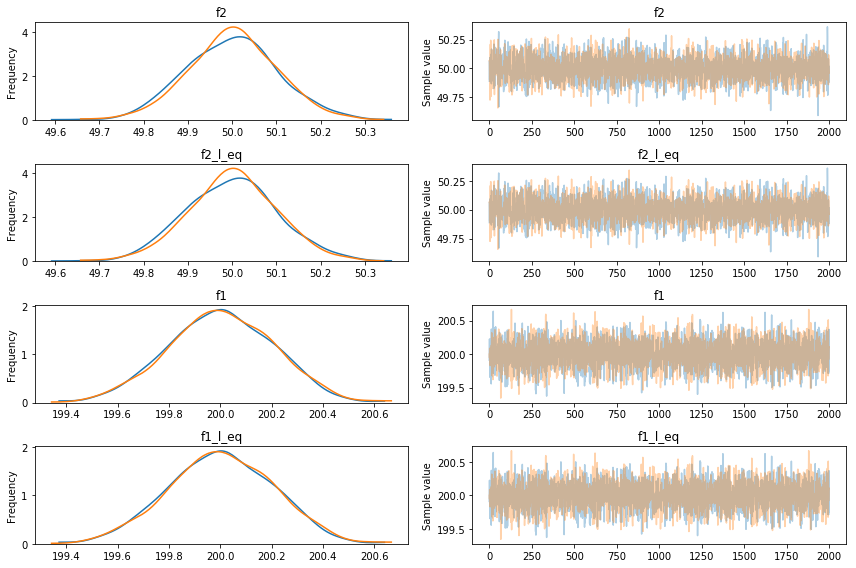

In [37]:
import numpy as np
# pm.traceplot(trace, ['f1_l_eq', 'f1_obs', 'f2_obs', 's_obs', 'f2_l_eq', 'f3_l_eq', 's_l_eq', 'a'])
pm.traceplot(trace, ['f2', 'f2_l_eq', 'f1', 'f1_l_eq'])



# Testing out graph based equations approach: 2 processes that link


In [17]:
with pm.Model() as double_process_model:
    # Process 1
    f1 = pm.Uniform('f1', lower=0, upper=1000, shape=1)
    f2 = pm.Uniform('f2', lower=0, upper=1000, shape=1)
    f3 = pm.Uniform('f3', lower=0, upper=1000, shape=1)
    f4 = pm.Uniform('f4', lower=0, upper=1000, shape=1)
            
    f3_nl_eq = pm.Deterministic('f3_nl_eq', (f1 + f2 + f4))
    
    f1_l_eq = pm.Deterministic('f1_l_eq', f3_nl_eq - f2 - f4)
    f2_l_eq = pm.Deterministic('f2_l_eq', f3_nl_eq - f1 - f4)
    f3_l_eq = pm.Deterministic('f3_l_eq', f1 + f2 + f4)
    f4_l_eq = pm.Deterministic('f4_l_eq', f3_nl_eq - f1_l_eq - f2_l_eq)

    # Process 2
    f5 = pm.Uniform('f5', lower=0, upper=1000, shape=1)
        
    a2 = pm.Uniform('a2', lower=0, upper=1, shape=1)
    
    f4_nl_eq = pm.Deterministic('f4_nl_eq', f3_l_eq*a2)
    f5_nl_eq = pm.Deterministic('f5_nl_eq', f3_l_eq*(1-a2))
    
    f4_l_eq2 = pm.Deterministic('f4_l_eq2', f3_l_eq - f5_nl_eq)
    f5_l_eq = pm.Deterministic('f5_l_eq', f3_l_eq - f4_l_eq2)
    
    f1_obs = pm.Normal('f1_obs', mu=f1_l_eq, sd=0.5, observed=20)
    f2_obs = pm.Normal('f2_obs', mu=f2_l_eq, sd=0.5, observed=9)    
    
    f4_obs = pm.Normal('f4_obs', mu=f4_l_eq2, sd=0.5, observed=6)
    f5_obs = pm.Normal('f5_obs', mu=f5_l_eq, sd=0.5, observed=29)
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2, f5, f4, f3, f2, f1]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:22<00:00, 940.44draws/s] 
The acceptance probability does not match the target. It is 0.8838330432634094, but should be close to 0.8. Try to increase the number of tuning steps.


KeyError: 'f4_l_eq2'

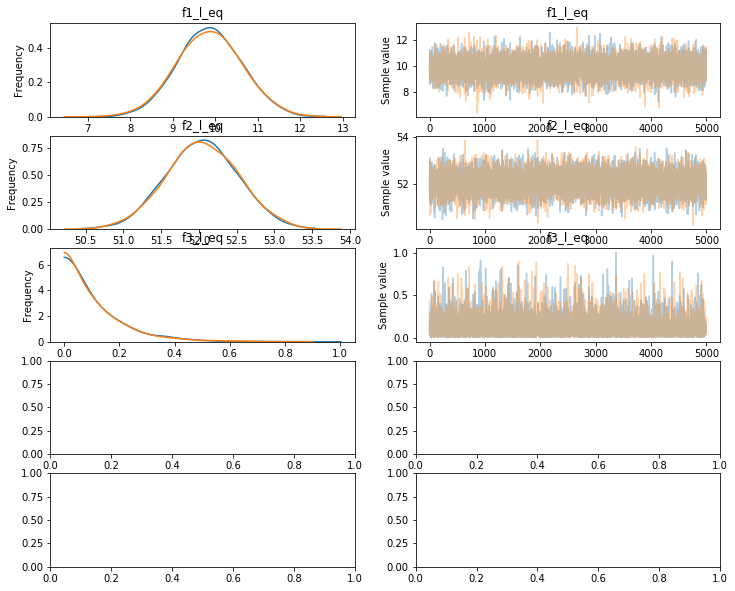

In [16]:
pm.traceplot(trace, ['f1_l_eq', 'f2_l_eq', 'f3_l_eq', 'f4_l_eq2', 'f5_l_eq'])

In [87]:
with pm.Model() as single_process_model:
    # Build model out of weak prior
    f1 = pm.Normal('f1', mu=20, sd=0.005, shape=1)
    f2 = pm.Normal('f2', mu=9, sd=0.001, shape=1)
    f3 = pm.Uniform('f3', lower=0, upper=1000, shape=1)
    
    s = pm.Normal('s', mu=7, sd=3, shape=1)
    
    a = pm.Uniform('a', lower=0, upper=1, shape=1)
    
    s_nl_eq = pm.Deterministic('s_nl_eq', (f1 + f2)*(1-a))
    f3_nl_eq = pm.Deterministic('f3_nl_eq', (f1 + f2)*(a))
    
    f1_l_eq = pm.Deterministic('f1_l_eq', f3_nl_eq + s_nl_eq - f2)
    f2_l_eq = pm.Deterministic('f2_l_eq', f3_nl_eq + s_nl_eq - f1_l_eq)
    f3_l_eq = pm.Deterministic('f3_l_eq', f1_l_eq + f2_l_eq - s_nl_eq)
    s_l_eq = pm.Deterministic('s_l_eq', f1_l_eq + f2_l_eq - f3_nl_eq)
    
    
    
    f1_obs = pm.Normal('f1_obs', mu=f1_l_eq, sd=1, observed=20)
    f3_obs = pm.Uniform('f3_obs', lower = )
    
    s_obs = pm.Normal('s_obs', mu=s_l_eq, sd=0.5, observed=7)
    
        
    trace = pm.sample(50000, cores=2, step=pm.Metropolis())
    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [a]
>Metropolis: [s]
>Metropolis: [f3]
>Metropolis: [f2]
>Metropolis: [f1]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:43<00:00, 2338.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16b27603c8>,
      dtype=object)

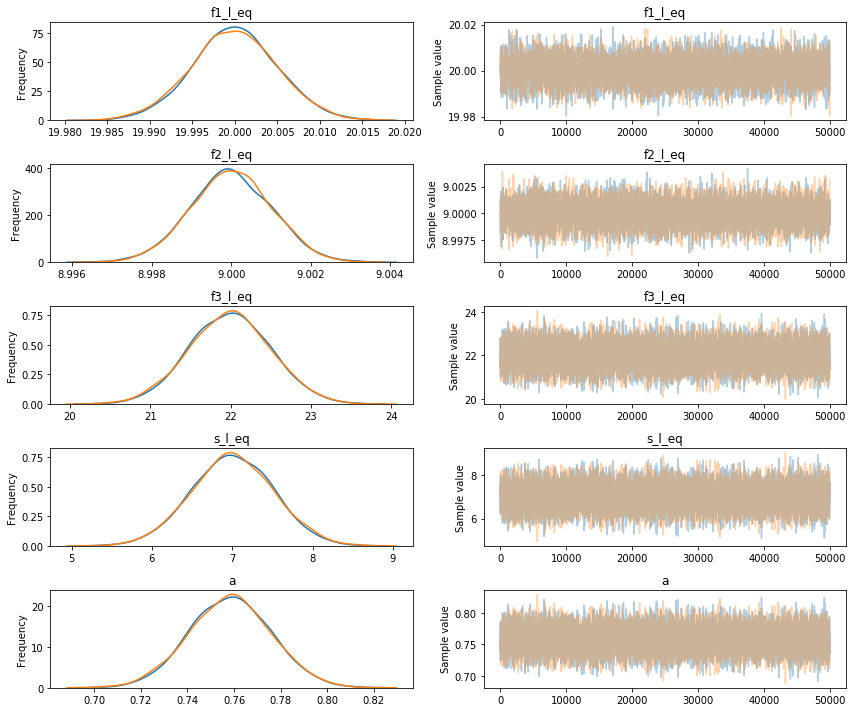

In [88]:
pm.traceplot(trace, ['f1_l_eq', 'f2_l_eq', 'f3_l_eq', 's_l_eq', 'a'])
